The [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) is one of the most widely used datasets as a benchmark for text classification. It consists of 11,855 sentences drawn from a corpus of movie reviews (originally from Rotten Tomatoes), each labeled with sentiment on a five-point scale.

For example:
```
sentence: [A warm , funny , engaging film .]
label:    4 (very positive)
```

For this assignment, we'll work with the binarized form of the dataset, where the lowest two classes are mapped to a single "negative" label, the highest two are mapped to a single "positive" label, and neutral examples are omitted.

Unlike most classification datasets, SST is also a **treebank, which means each sentence is associated with a tree structure that decomposes it into subphrases.** So for the example above, we'd also have sentiment labels for `[warm , funny]` and `[engaging film .]` and so on. The trees are created by running the [Stanford Parser](https://nlp.stanford.edu/software/lex-parser.shtml) over the original sentences, then crowdsourcing sentiment labels on each sub-phrase. 

For the purposes of this assignment, we'll mostly concern ourselves with the sentence-level ("root") labels, but the tree structure will come in handy in two places:
- As a way of analyzing the examples to find instances of negation
- (optionally) As a source of additional training data, by including phrase labels


## Obtaining the Data
The data is distributed as serialized trees in [S-expression](https://en.wikipedia.org/wiki/S-expression) form, like this:
```
(4 (4 (2 A) (4 (3 (3 warm) (2 ,)) (3 funny))) (3 (2 ,) (3 (4 (4 engaging) (2 film)) (2 .))))
```

We've provided an `SSTDataset` class (in `sst.py`) which will download the dataset and parse the S-expressions into [`nltk.tree.Tree`](http://www.nltk.org/api/nltk.html?highlight=tree#nltk.tree.Tree) objects that you can easily view in the notebook.

`SSTDataset` also implements the text-processing pipeline described in the [Prelude notebook](Prelude.ipynb), and provides methods (`as_sparse_bow` and `as_padded_array`) to convert the data to matrix form.

Run the cell below; it will download a ~6MB .zip file to the local directory the first time you run it.

In [ ]:
# Install a few python packages using pip
from w266_common import utils
utils.require_package("wget")      # for fetching dataset
utils.require_package("bokeh")     # for plotting histograms
utils.require_package("graphviz")  # for rendering trees

# for Implement Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# NLTK, NumPy, and Pandas.
import nltk # NLTK for NLP utils and corpora
import numpy as np
import pandas as pd

# TensorFlow
import tensorflow as tf
from tensorflow import keras

In [9]:
import sst
ds = sst.SSTDataset(V=20000).process(label_scheme="binary")

Loading SST from data/sst/trainDevTestTrees_PTB.zip
Training set:     8,544 trees
Development set:  1,101 trees
Test set:         2,210 trees
Building vocabulary - 16,474 words
Processing to phrases...  Done!
Splits: train / dev / test : 98,794 / 13,142 / 26,052


A few members of the `SSTDataset()` class that you might find useful (click through and skim read):
- **`ds.vocab`**: a [`vocabulary.Vocabulary`](https://github.com/datasci-w266/2021-summer-main/blob/master/common/vocabulary.py#L8) object managing the model vocabulary
- **`ds.{train,dev,test}_trees`**: a list of [`nltk.tree.Tree`](http://www.nltk.org/api/nltk.html?highlight=tree#nltk.tree.Tree) objects representing each sentence
- **`ds.{train,dev,test}`**: a Pandas DataFrame containing the _processed_ examples, including all subphrases. `label` is the target label, `is_root` denotes whether this example is a root node (full sentence), and `root_id` is the index of the tree that the example was derived from.

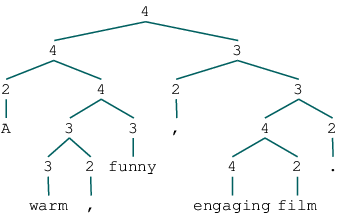

In [11]:
# Look at a tree for a positive review
ds.dev_trees[3]

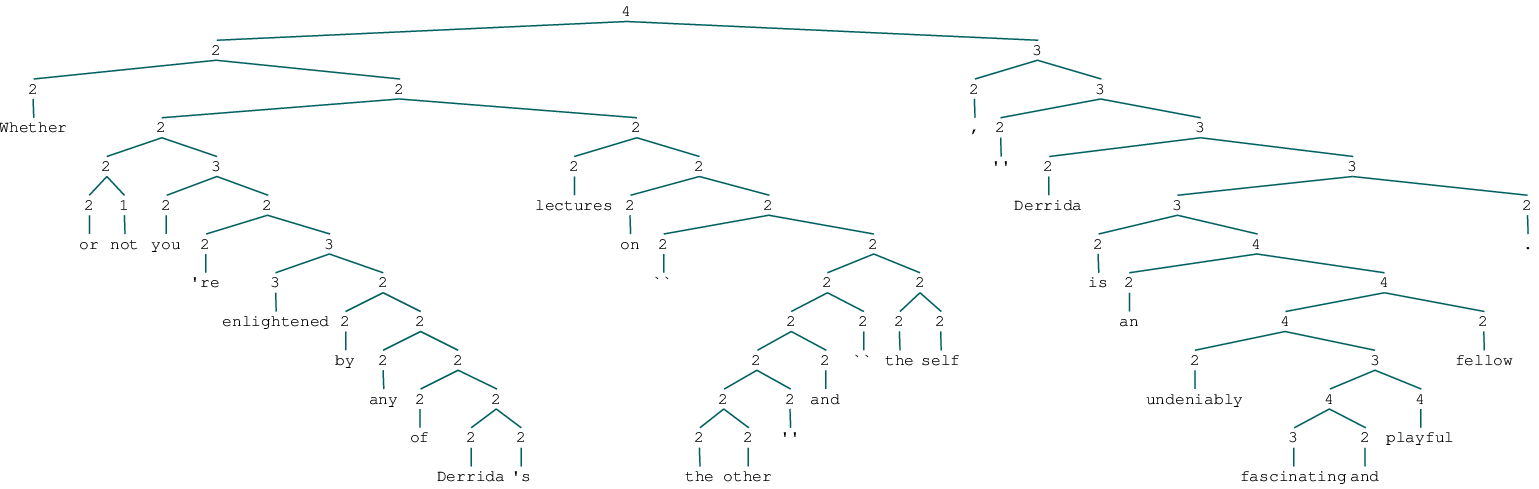

In [13]:
ds.train_trees[5]

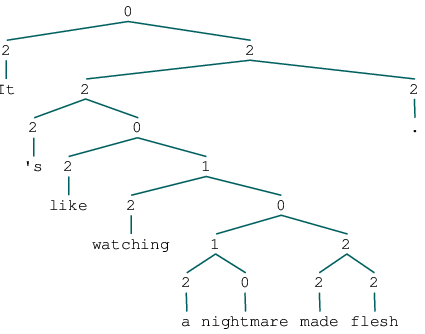

In [15]:
ds.dev_trees[361]

# Naive Bayes

In this section, we'll build and explore a Naive Bayes model as a baseline classifier for our dataset.

**Naive Bayes is perhaps the simplest possible classification algorithm, but it's one that still surprisingly effective for many text classification problems.**

$$ P(y = k) = \hat{\theta}_k = \frac{1}{N}\sum_{i = 1}^N \mathbf{1}[y_i = k] $$

$$ P(x_j | y = 1) = \hat{\theta}_{k,j} = 
\frac{ 
\sum_{i = 1}^N  \sum_{j' = 1}^{n_i} \mathbf{1}[y_i = 1 \wedge x_{j'} = j]
}{
\sum_{i = 1}^N  \mathbf{1}[y_i = 1] \cdot n_i
}
$$

where $N$ is the size of the dataset, and $n_i$ is the length (number of tokens of the $i^{th}$ example. Prediction is done by computing the score:

$$ \mathrm{score}(x) = \log \left(\frac{P(y = 1) \prod_{j=1}^n P(x_j | y = 1)}{P(y = 0) \prod_{j=1}^n P(x_j | y = 0)}\right) $$

We'll just use the [implementation from scikit-learn](http://scikit-learn.org/stable/modules/naive_bayes.html). Like other scikit-learn classifiers, this expects the input as a `scipy.sparse` matrix. Run the cell below:

In [16]:
# 'csr' stands for "Compressed Sparse Row", which is one format
# for representing sparse matricies.
train_x_csr, train_y = ds.as_sparse_bow("train", root_only=True)
test_x_csr,  test_y  = ds.as_sparse_bow("test", root_only=True)
print("Training set: x = {:s} sparse, y = {:s}".format(str(train_x_csr.shape), 
                                                str(train_y.shape)))
print("Test set:     x = {:s} sparse, y = {:s}".format(str(test_x_csr.shape), 
                                                str(test_y.shape)))

Training set: x = (6920, 16474) sparse, y = (6920,)
Test set:     x = (1821, 16474) sparse, y = (1821,)


In [19]:
# apply for the Naive Bayes model
nb = MultinomialNB()
nb.fit(train_x_csr, train_y)
y_pred = nb.predict(test_x_csr)
acc = accuracy_score(test_y, y_pred)
print("Accuracy on test set: {:.05%}".format(acc))

Accuracy on test set: 82.20758%


In [22]:
# find the top 10 most negative and most positive weights. 
linear_weights = None  # populate this with actual values
linear_weights = nb.feature_log_prob_[1,:]-nb.feature_log_prob_[0,:]  # populate this with actual values
top_negative_features = np.argsort(linear_weights)[:10]
top_positive_features = np.argsort(-linear_weights)[:10]


print("Most negative features:")
for idx in top_negative_features:
    print("  {:s} ({:.05f})".format(ds.vocab.id_to_word[idx], 
                                    linear_weights[idx]))
print("")
print("Most positive features:")
for idx in top_positive_features:
    print("  {:s} ({:.05f})".format(ds.vocab.id_to_word[idx], 
                                    linear_weights[idx]))

Most negative features:
  stupid (-3.17052)
  suffers (-3.07521)
  unfunny (-2.96985)
  mess (-2.78753)
  pointless (-2.78753)
  flat (-2.75362)
  poorly (-2.71853)
  car (-2.71853)
  tiresome (-2.64443)
  disguise (-2.56438)

Most positive features:
  powerful (3.53144)
  solid (3.44688)
  perfectly (2.81090)
  inventive (2.69311)
  refreshing (2.62857)
  touching (2.55958)
  wonderful (2.48547)
  riveting (2.48547)
  portrait (2.40543)
  thought-provoking (2.40543)


## Examining 
While Naive Bayes performs well in the aggregate, as a linear model it's still limited in its ability to model complex phenomena in the data. **Each feature - in this case, each word - contributes a weight to the total, and if the sum is  ≥0  we predict the example is positive.** But what happens when we have an example with both positive and negative words? For instance:

In [26]:
# Example with both positive and negative words? For instance:
examples = ["Brando 's performance fell short of the high standards set by his earlier work .",
            "A thoughtful look at a painful incident that made headlines in 1995 ."]
canonicalized_examples = [ds.canonicalize(s.split()) for s in examples]
id_lists = [ds.vocab.words_to_ids(s) for s in canonicalized_examples]
x = utils.id_lists_to_sparse_bow(id_lists, ds.vocab.size)
nb.predict(x)

array([1, 1], dtype=int32)

In [27]:
[x for x in zip(canonicalized_examples[0], linear_weights[np.array(id_lists[0])])]

[('<unk>', -0.07947581123340974),
 ("'s", 0.032134724769587564),
 ('performance', 1.0991791851082366),
 ('fell', -0.7726229917933551),
 ('short', -0.5213085635124504),
 ('of', 0.1577996227186711),
 ('the', 0.035492833505731625),
 ('high', -0.07947581123341152),
 ('standards', 0.6136713693265357),
 ('set', -0.18483632689123652),
 ('by', -0.03560912912782843),
 ('his', 0.15123398046411562),
 ('earlier', -0.995766543107564),
 ('work', 0.4801399767020129),
 ('.', 0.0184617237532958)]

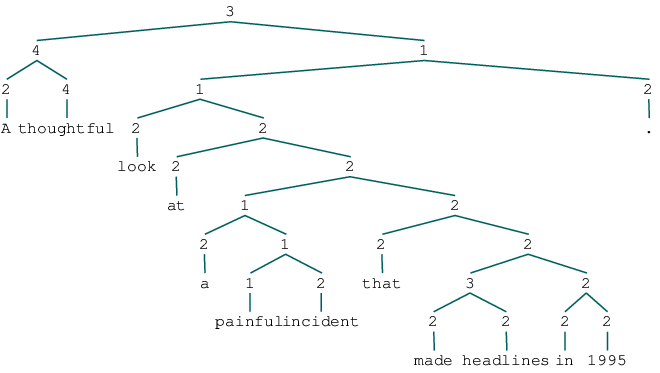

In [28]:
ds.test_trees[210]

count up all the non-neutral phrases for a given sentence, and look at ones where there's a mix of both positive and negative labels.

In [29]:
df = ds.test
gb = df.groupby(by=['root_id'])
interesting_ids = []   # root ids, index into ds.test_trees
interesting_idxs = []  # DataFrame indices, index into ds.test

# This groups the DataFrame by sentence
for root_id, idxs in gb.groups.items():
    # Get the average score of all the phrases for this sentence
    mean = df.loc[idxs].label.mean()
    if (mean > 0.4 and mean < 0.6):
        interesting_ids.append(root_id)
        interesting_idxs.extend(idxs)
        
print("Found {:,} interesting examples".format(len(interesting_ids)))

# This will extract only the "interesting" sentences we found above
test_x_interesting, test_y_interesting = ds.as_sparse_bow("test", root_only=True, 
                                                          df_idxs=interesting_idxs)
print("Interesting ids (into ds.test_trees): ", interesting_ids)

Found 246 interesting examples
Interesting ids (into ds.test_trees):  [0, 27, 31, 32, 75, 80, 90, 96, 117, 124, 138, 140, 141, 160, 166, 186, 187, 205, 210, 212, 227, 232, 254, 269, 271, 285, 296, 307, 312, 327, 335, 373, 397, 399, 406, 407, 410, 426, 447, 511, 512, 516, 521, 534, 539, 563, 577, 588, 606, 610, 611, 637, 640, 645, 655, 662, 664, 713, 720, 721, 724, 739, 755, 758, 763, 776, 791, 793, 796, 802, 805, 810, 818, 840, 858, 887, 898, 899, 909, 910, 912, 929, 930, 961, 970, 973, 974, 975, 979, 1008, 1032, 1036, 1066, 1067, 1076, 1098, 1101, 1108, 1114, 1131, 1138, 1142, 1159, 1183, 1185, 1189, 1193, 1198, 1206, 1214, 1215, 1235, 1241, 1243, 1244, 1261, 1267, 1273, 1275, 1279, 1280, 1293, 1296, 1302, 1303, 1312, 1318, 1319, 1321, 1322, 1324, 1326, 1328, 1338, 1341, 1346, 1359, 1363, 1371, 1383, 1398, 1402, 1413, 1443, 1452, 1456, 1458, 1462, 1464, 1480, 1481, 1486, 1487, 1488, 1507, 1509, 1513, 1516, 1527, 1537, 1552, 1576, 1582, 1587, 1594, 1597, 1602, 1607, 1608, 1615, 1619, 1

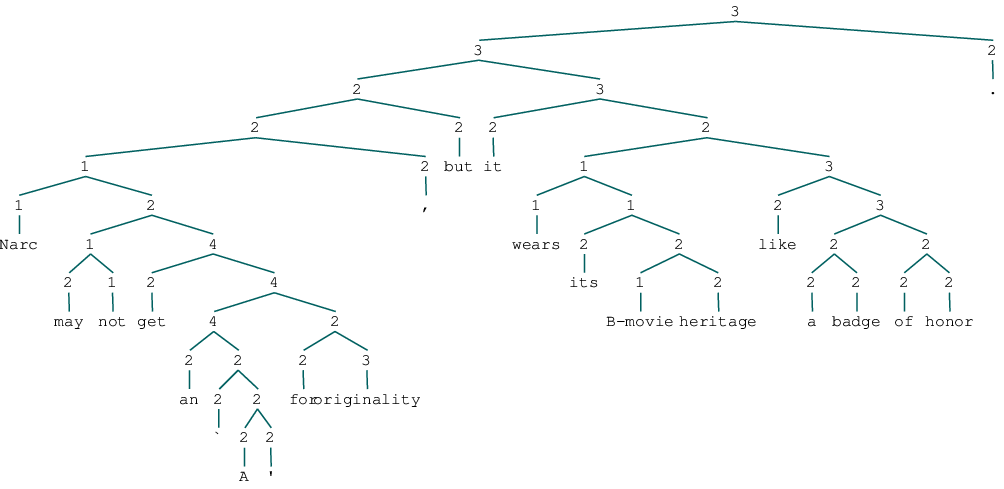

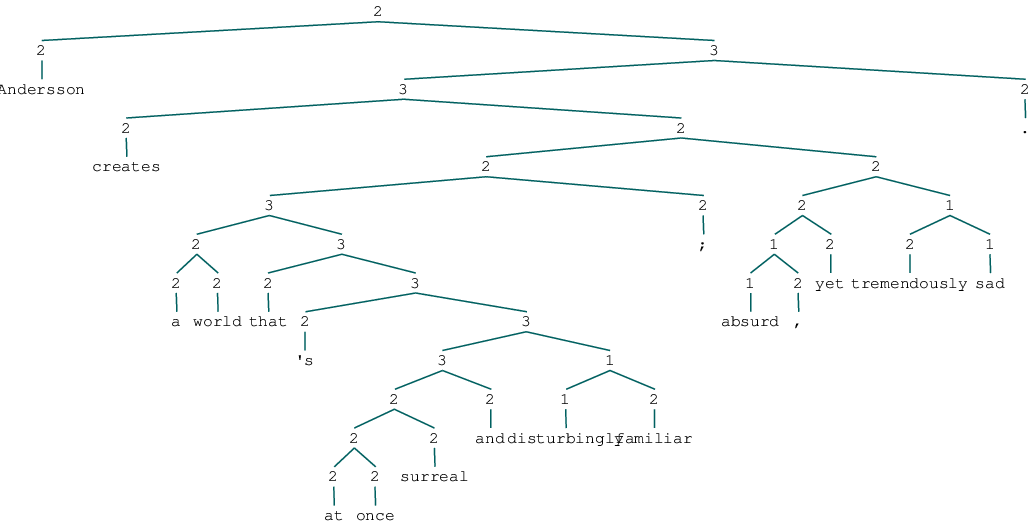

In [30]:
##  Examine a few of the "interesting" trees
display(ds.test_trees[interesting_ids[17]])
display(ds.test_trees[interesting_ids[65]])

In [32]:
y_pred = nb.predict(test_x_interesting)
acc = accuracy_score(test_y_interesting, y_pred) 
print("Accuracy on selected examples: {:.02f}%".format(100*acc))

Accuracy on selected examples: 73.26%


# CNN

We'll use the following notation:
- $h$: filter/kernel length (in words)
- $w^{(i)} \in \mathbb{Z}$, the word id for the $i^{th}$ word of the sequence (as an integer index)
- $x^{(i)} \in \mathbb{R}^d$ for the vector representation (embedding) of $w^{(i)}$
- $x^{i:i+j}$ is the concatenation of $x^{(i)}, x^{(i+1)} ... x^{(i+j)}$ 
- $c^{(i)}_{k}$ is the value of the $k^{th}$ feature map at the $i^{th}$ position along the word sequence, each filter applies over a window of $h$ words and uses non-linearity $f$.
- $c_k$ is one feature map (the $k_{th}$).  Its values are $c^{(0)}_{k}$, $c^{(1)}_{k}$, $c^{(2)}_{k}$, ...
- $\hat{c}_{k}$ is the value of the $k^{th}$ feature after pooling the feature map over the whole sequence.
- $\hat{C}$ is the concatenation of pooled feature maps. 
- $y$ for the target label ($\in 1,\ldots,\mathtt{num\_classes}$)

Our model is defined as:
- **Embedding layer:** $x^{(i)} = W_{embed}[w^{(i)}]$
- **Convolutional layer:** $c^{(i)}_{k} = f(x^{i:i+h-1} W_k + b)$
- **Pooling layer:**  $\hat{c}_{k}$ = $max(c_k)$ = $max(c^{(0)}_{k}, c^{(1)}_{k}...)$ 
- **Output layer:** $\hat{y} = \hat{P}(y) = \mathrm{softmax}(\hat{C} W_{out} + b_{out})$


We'll refer to the first part of this model (**Embedding layer**, **Convolutional layer**, and **Pooling layer**) as the **Encoder**: it has the role of encoding the input sequence into a fixed-length vector representation that we pass to the output layer.

We'll also use these as shorthand for important dimensions:
- `V`: the vocabulary size (equal to `ds.vocab.size`)
- `N`: the maximum number of tokens in the input text
- `embed_dim`: the embedding dimension $d$
- `filters`: number filters per filter length
- `num_classes`: the number of target classes (2 for the binary task)

In [33]:
max_len = 40
train_x, train_ns, train_y = ds.as_padded_array('train', max_len=max_len, root_only=True)
dev_x,   dev_ns,   dev_y   = ds.as_padded_array('dev',   max_len=max_len, root_only=True)
test_x,  test_ns,  test_y  = ds.as_padded_array('test',  max_len=max_len, root_only=True)

In [34]:
# Specify model hyperparameters.
epochs = 10
embed_dim = 5
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = []
dropout_rate = 0.7
num_classes = len(ds.target_names)

In [37]:
# Construct the convolutional neural network.
# The form of each keras layer function is as follows:
#    result = keras.layers.LayerType(arguments for the layer)(layer(s) it should use as input)
# concretely,
#    this_layer_output = keras.layers.Dense(100, activation='relu')(prev_layer_vector)
# performs this_layer_output = relu(prev_layer_vector x W + b) where W has 100 columns.

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len,))

In [38]:
# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)

In [40]:
# Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
# With the default hyperparameters, we construct 2 filters each of size 2, 3, 4.  As in the image above, each filter
# is wide enough to span the whole word embedding (this is why the convolution is "1d" as seen in the
# function name below).
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

In [41]:
# Concat the feature maps from each different size.
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

In [42]:
# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

In [49]:
# Add a fully connected layer for each dense layer dimension in dense_layer_dims.
h = keras.layers.Dense(10, activation='relu')(h)

In [50]:
prediction = keras.layers.Dense(num_classes, activation='softmax')(h)
model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # From information theory notebooks.
              metrics=['accuracy']) 

In [51]:
model.reset_states()
model.fit(train_x, train_y, epochs=epochs)

Epoch 1/10
217/217 [==============================] - 1s 984us/step - loss: 0.8816 - accuracy: 0.5020
Epoch 2/10
217/217 [==============================] - 0s 1ms/step - loss: 0.4588 - accuracy: 0.7766
Epoch 3/10
217/217 [==============================] - 0s 986us/step - loss: 0.3802 - accuracy: 0.7864
Epoch 4/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3684 - accuracy: 0.7773
Epoch 5/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3640 - accuracy: 0.7674
Epoch 6/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3431 - accuracy: 0.7823
Epoch 7/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3381 - accuracy: 0.7885
Epoch 8/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3370 - accuracy: 0.7875
Epoch 9/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3407 - accuracy: 0.7883
Epoch 10/10
217/217 [==============================] - 0s 1ms/step - loss: 0.3459 - accuracy: 0.

In [52]:
model.evaluate(dev_x, dev_y)

28/28 [==============================] - 0s 545us/step - loss: 0.6354 - accuracy: 0.7271


[0.635402500629425, 0.7270641922950745]

### Tuning CNN Model

In [53]:
def build_cnn_model(num_filters, kernel_sizes): 
    #  number filters per filter length
    #  The kernel size refers to the width x height of the filter mask.
    
    epochs = 10
    embed_dim=5 # the embedding dimension
    dropout_rate = 0.8
    num_classes = 2

    # Construct the convolutional neural network.
    # The form of each keras layer function is as follows:
    #    result = keras.layers.LayerType(arguments for the layer)(layer(s) it should use as input)
    # concretely,
    #    this_layer_output = keras.layers.Dense(100, activation='relu')(prev_layer_vector)
    # performs this_layer_output = relu(prev_layer_vector x W + b) where W has 100 columns.

    # Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
    # In our case, we are accepting a list of wordids (padded out to max_len).
    wordids = keras.layers.Input(shape=(max_len,))

    # Embed the wordids.
    h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)

    # Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
    # With the default hyperparameters, we construct 10 filters each of size 2, 3, 4.  As in the image above, each filter
    # is wide enough to span the whole word embedding (this is why the convolution is "1d" as seen in the
    # function name below).
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    # Concat the feature maps from each different size.
    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
    # in the vector.
    # See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
    h = keras.layers.Dropout(rate=dropout_rate)(h)
    # Add a fully connected layer for each dense layer dimension in dense_layer_dims.
    h = keras.layers.Dense(5, activation='relu')(h)

    prediction = keras.layers.Dense(num_classes, activation='softmax')(h)

    model = keras.Model(inputs=wordids, outputs=prediction)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # From information theory notebooks.
                  metrics=['accuracy'])
    
    return model

In [56]:
from random import randint
num_runs = 10

In [73]:
num_filter_list = []
for i in range(0,num_runs):
    rand_int = randint(3,10)
    num_filter_list.append([rand_int,rand_int,rand_int])

In [74]:
num_filter_list

[[9, 9, 9],
 [6, 6, 6],
 [6, 6, 6],
 [9, 9, 9],
 [5, 5, 5],
 [7, 7, 7],
 [5, 5, 5],
 [7, 7, 7],
 [5, 5, 5],
 [6, 6, 6]]

In [75]:
kernel_size_list = []
for i in range(0,num_runs):
    kernel_size_list.append([randint(1,7), randint(1,10), randint(1,13)])

In [76]:
kernel_size_list

[[6, 6, 1],
 [5, 3, 3],
 [1, 2, 9],
 [6, 1, 5],
 [6, 5, 5],
 [2, 5, 5],
 [3, 10, 7],
 [4, 5, 7],
 [1, 5, 8],
 [7, 7, 10]]

In [80]:
model_performance = []    
    
for num_filters, kernel_sizes in zip(num_filter_list, kernel_size_list):
    model = build_cnn_model(num_filters, kernel_sizes)
    model.reset_states()
    model.fit(train_x, train_y,epochs=epochs, verbose=0)
    loss_train, accuracy_train = model.evaluate(train_x, train_y,verbose=0)
    loss_dev, accuracy_dev = model.evaluate(dev_x, dev_y,verbose=0)
    print(f"number of filters {num_filters}, kernel sizes {kernel_sizes}:")
    print("    train loss: {:.03f}, train accuracy: {:.03%}".format(loss_train,accuracy_train))
    print("    dev loss: {:.03f}, dev accuracy: {:.03%}".format(loss_dev,accuracy_dev))

number of filters [9, 9, 9], kernel sizes [6, 6, 1]:
    train loss: 0.031, train accuracy: 98.945%
    dev loss: 1.069, dev accuracy: 74.427%
number of filters [6, 6, 6], kernel sizes [5, 3, 3]:
    train loss: 0.068, train accuracy: 98.237%
    dev loss: 1.084, dev accuracy: 72.706%
number of filters [6, 6, 6], kernel sizes [1, 2, 9]:
    train loss: 0.090, train accuracy: 97.934%
    dev loss: 0.944, dev accuracy: 72.821%
number of filters [9, 9, 9], kernel sizes [6, 1, 5]:
    train loss: 0.032, train accuracy: 98.829%
    dev loss: 1.033, dev accuracy: 72.936%
number of filters [5, 5, 5], kernel sizes [6, 5, 5]:
    train loss: 0.059, train accuracy: 97.890%
    dev loss: 0.762, dev accuracy: 76.376%
number of filters [7, 7, 7], kernel sizes [2, 5, 5]:
    train loss: 0.045, train accuracy: 98.671%
    dev loss: 0.813, dev accuracy: 73.739%
number of filters [5, 5, 5], kernel sizes [3, 10, 7]:
    train loss: 0.052, train accuracy: 98.699%
    dev loss: 0.909, dev accuracy: 75.115